In [1]:
import argparse
import datetime
import os
import traceback

import numpy as np
import torch
import yaml
from tensorboardX import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm

from backbone import EfficientDetBackbone
from efficientdet.dataset import BrainDataset, Resizer, Normalizer, Augmenter, collater
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string
import json

data_path = '/home/kuchoco97/work/brain/data/bbox_data/'

with open(data_path + 'box_only_train.json', 'r') as file:
    train_json = json.load(file)

with open(data_path + 'box_only_valid.json', 'r') as file:
    valid_json = json.load(file)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check
# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name())
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated()/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached()/1024**3,1), 'GB')

Current cuda device  0
TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [3]:
class Params:
    def __init__(self, project_file):
        self.params = yaml.safe_load(open(project_file).read())

    def __getattr__(self, item):
        return self.params.get(item, None)

    
    
params = Params('projects/brain.yml')

train_ds = BrainDataset(train_json, transform=Resizer())

validation_ds  = BrainDataset(valid_json, transform=Resizer())

training_generator = DataLoader(train_ds,
                          batch_size=32,
                          num_workers=4,
                          shuffle=True,
                          collate_fn = collater)

val_generator = DataLoader(validation_ds,
                               batch_size=32,
                               num_workers=4,
                               shuffle=True,
                               collate_fn = collater)

----------------
# How to Infer

In [4]:
import torch
from torch.backends import cudnn
import cv2
import matplotlib.pyplot as plt
from backbone import EfficientDetBackbone

In [5]:
class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


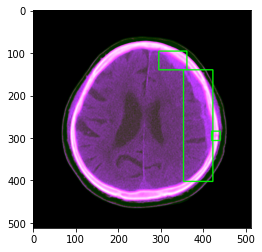

In [12]:
# ground truth

img = validation_ds[331]['img']
img = np.array(img)
img_clone = img.copy()

for annot in validation_ds[331]['annot']:
    x_min, y_min, x_max, y_max, _ = np.array(annot, dtype=int)
    cv2.rectangle(img_clone, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
    
plt.imshow(img_clone)
plt.show()

In [7]:
def aspectaware_resize_padding(image, width, height, interpolation=None, means=None):
    old_h, old_w, c = image.shape
    if old_w > old_h:
        new_w = width
        new_h = int(width / old_w * old_h)
    else:
        new_w = int(height / old_h * old_w)
        new_h = height

    canvas = np.zeros((height, height, c), np.float32)
    if means is not None:
        canvas[...] = means

    if new_w != old_w or new_h != old_h:
        if interpolation is None:
            image = cv2.resize(image, (new_w, new_h))
        else:
            image = cv2.resize(image, (new_w, new_h), interpolation=interpolation)

    padding_h = height - new_h
    padding_w = width - new_w

    if c > 1:
        canvas[:new_h, :new_w] = image
    else:
        if len(image.shape) == 2:
            canvas[:new_h, :new_w, 0] = image
        else:
            canvas[:new_h, :new_w] = image

    return canvas, new_w, new_h, old_w, old_h, padding_w, padding_h,

In [8]:
def preprocess(img, max_size=512, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    ori_imgs = [img]
    imgs_meta = [aspectaware_resize_padding(img, max_size, max_size,
                                            means=None) for img in ori_imgs]
    framed_imgs = [img_meta[0] for img_meta in imgs_meta]
    framed_metas = [img_meta[1:] for img_meta in imgs_meta]

    return ori_imgs, framed_imgs, framed_metas

In [13]:
img = validation_ds[331]['img']
img = np.array(img)
a, b, c = preprocess(img)

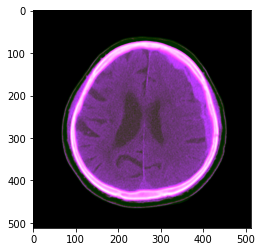

In [14]:
plt.imshow(b[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


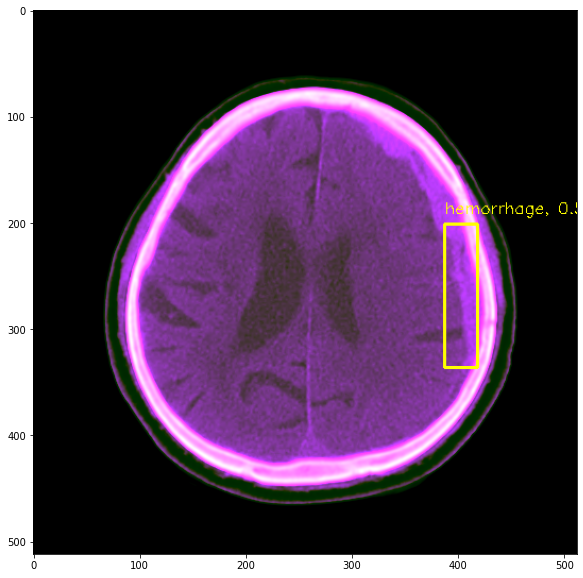

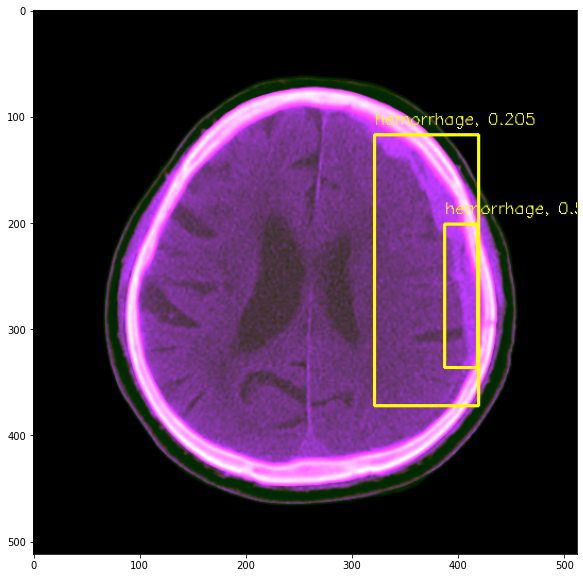

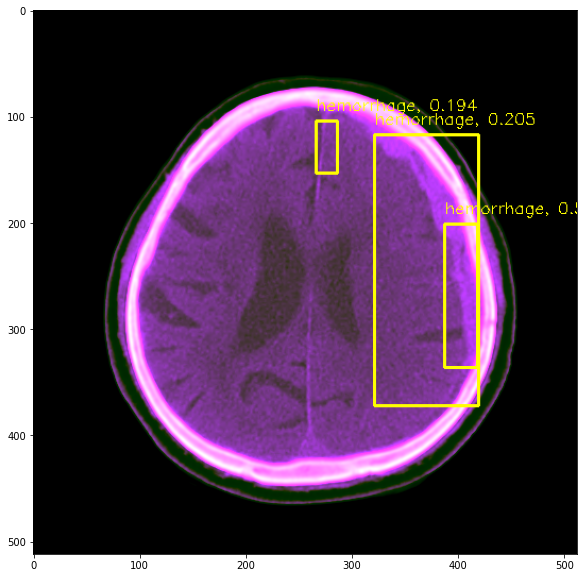

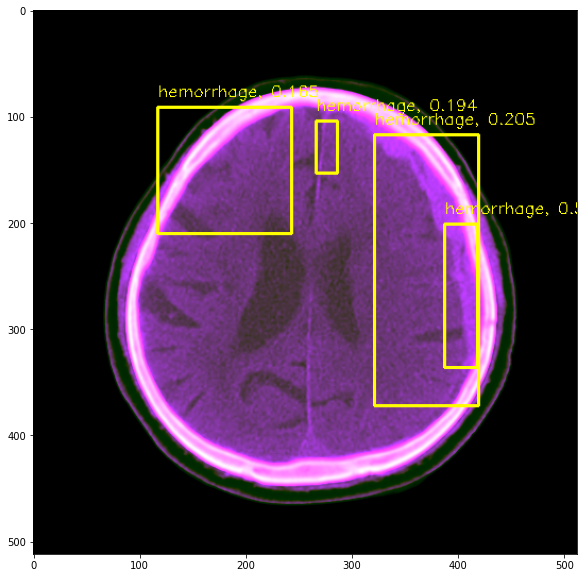

In [20]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import invert_affine, postprocess, aspectaware_resize_padding

compound_coef = 0
force_input_size = None  # set None to use default size

score_threshold = 0.15
nms_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = [ 'hemorrhage', 'fracture' ]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

eff_model = EfficientDetBackbone(num_classes= 2, compound_coef=0,
                                 ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

eff_model.load_state_dict(torch.load('./logs/efficientdet-d0_198_13300.pth'))
eff_model.requires_grad_(False)
eff_model.eval()

if use_cuda:
    eff_model = eff_model.cuda()
if use_float16:
    eff_model = eff_model.half()

with torch.no_grad():
    features, regression, classification, anchors = eff_model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      score_threshold, nms_threshold)


out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)
        plt.figure(figsize=(10,10))
        plt.imshow(ori_imgs[i])


## Metic 평가

In [30]:
from metric import AP, IoU
from tqdm import tqdm

score_threshold = 0.3
nms_threshold = 0.3
iou_threshold = 0.4 

total_pos = 0
total_TP = 0
total_FP = 0 

for ds in tqdm(validation_ds):
    image, annot, _ = ds.values()

    image = image.permute(2,0,1).unsqueeze(0).cuda()

    with torch.no_grad():
        features, regression, classification, anchors = eff_model(image)
        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(image,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          score_threshold, nms_threshold)[0]
        rois, class_pred, scores = out.values()
    
    ret = AP(annot, rois, class_pred, iou_threshold= iou_threshold)
    for i in ret:
        total_TP += i['total TP']
        total_FP += i['total FP']
        total_pos += i['total positives']

  0%|          | 0/529 [00:00<?, ?it/s]/home/kuchoco97/work/Yet-Another-EfficientDet-Pytorch/metric.py:66: RuntimeWarning: invalid value encountered in double_scalars
  rec = TP / n_pos
/home/kuchoco97/work/Yet-Another-EfficientDet-Pytorch/metric.py:67: RuntimeWarning: invalid value encountered in true_divide
  prec = np.divide(TP, (FP + TP))
100%|██████████| 529/529 [00:27<00:00, 19.34it/s]


In [34]:
total_pos, total_TP, total_FP

(1483, 212.0, 708.0)